# Playground Series - S3E25

### Your Goal: For this Episode of the Series, your task is to use regression to predict the Mohs hardness of a mineral, given its properties. Good luck!

Evaluation metric: $ \( \text{MedAE}(y, \hat{y}) = \text{median}(|y_i - \hat{y}_i|, \ldots, |y_n - \hat{y}_n|) \) $



In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

from sklearn.svm import SVR
import sweetviz as sv
import xgboost as xgb
import zipfile

from tools.eda_helper import eda_ols

In [2]:
# parameters
random_state=42
target_col = 'Hardness'

In [3]:
with zipfile.ZipFile('../../../../res/data/playground-series-s3e25.zip', 'r') as z:
    
    with z.open('train.csv') as f:
        train= pd.read_csv(f,)        
                
    with z.open('test.csv') as f:
        test = pd.read_csv(f,)

## EDA

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



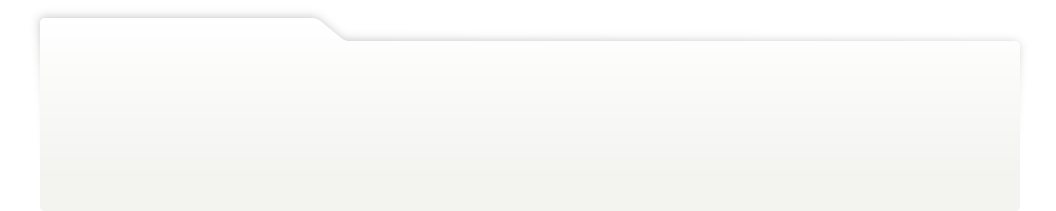
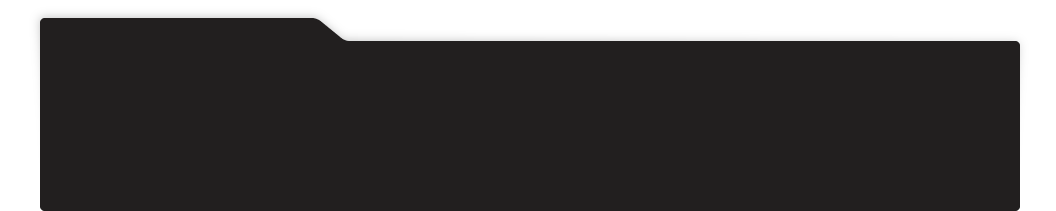
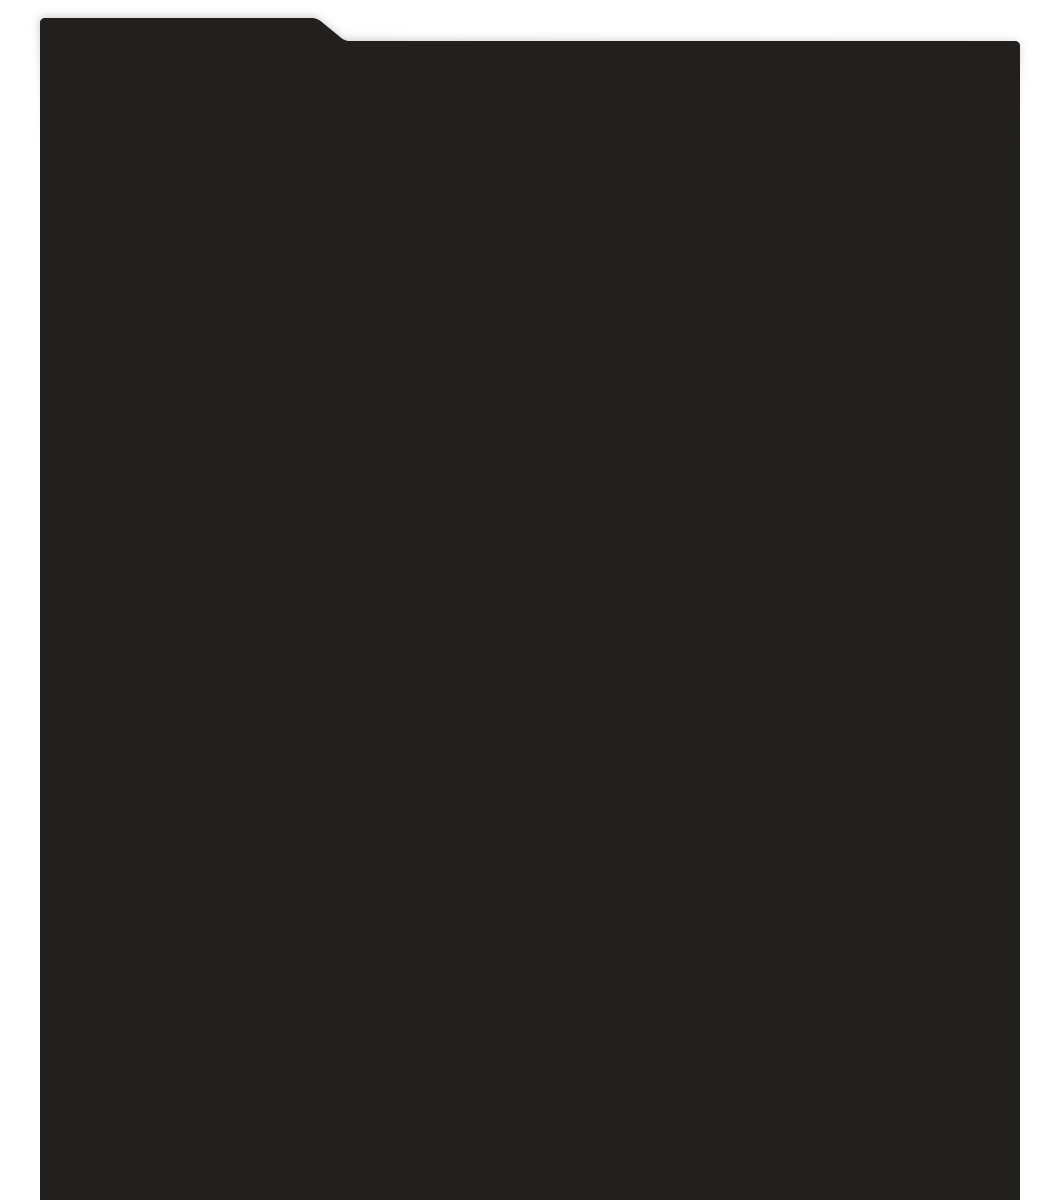
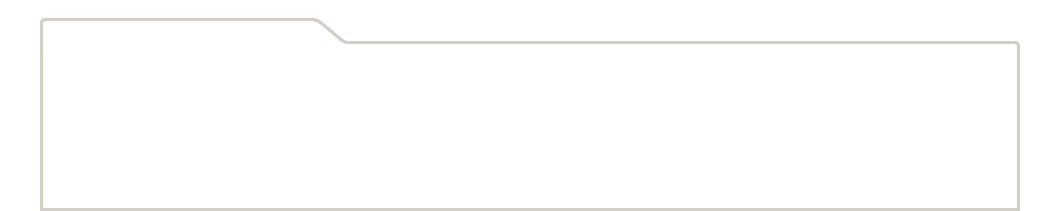
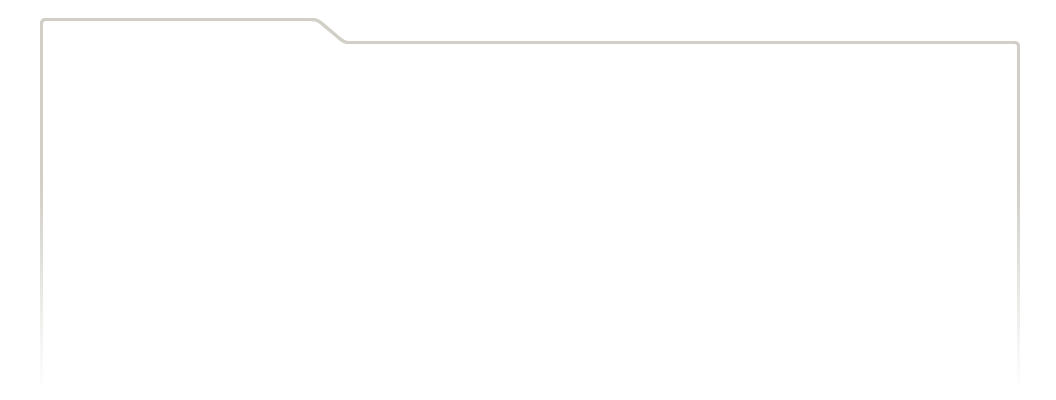
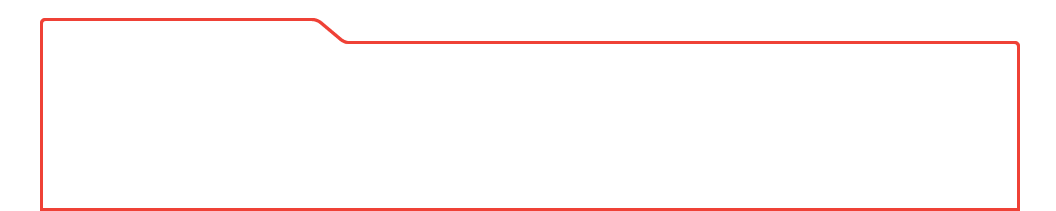
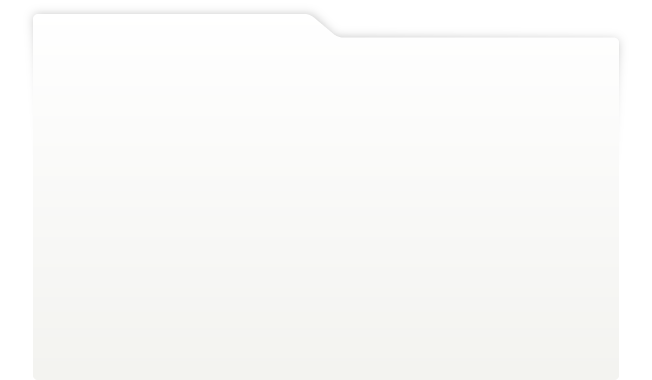
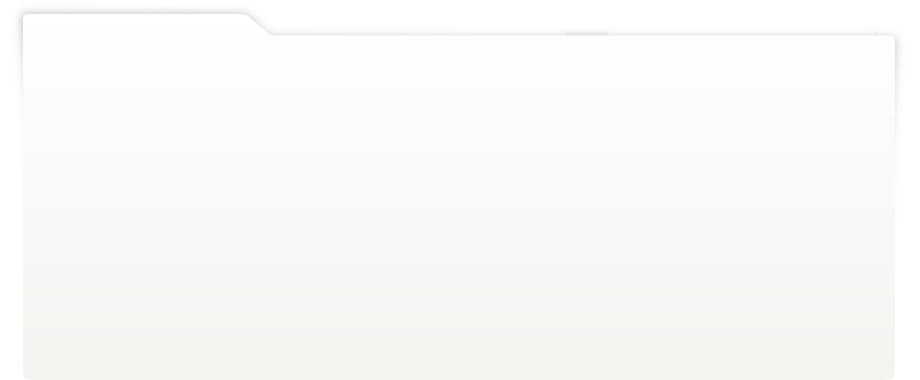
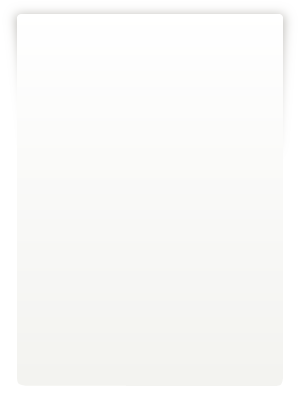
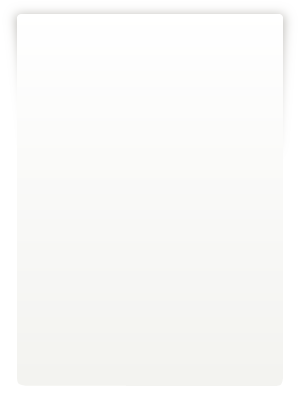
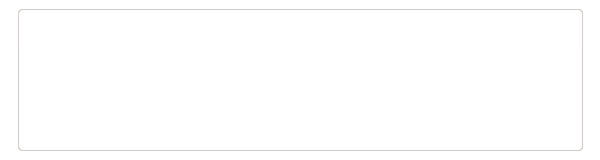
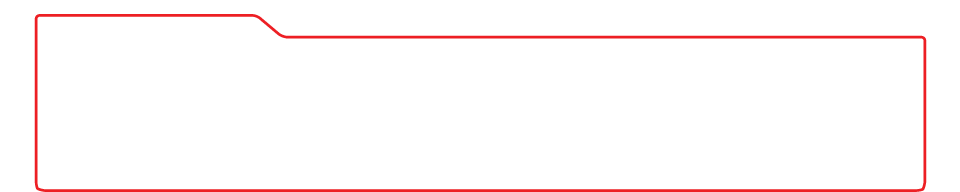
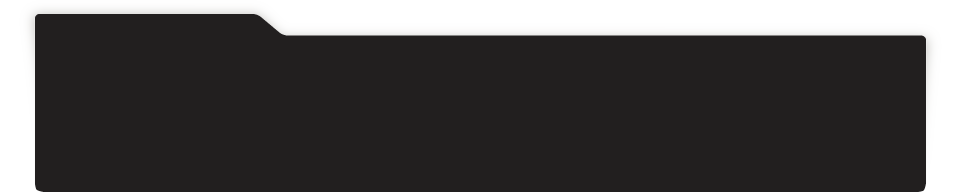
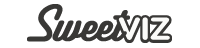
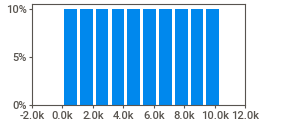
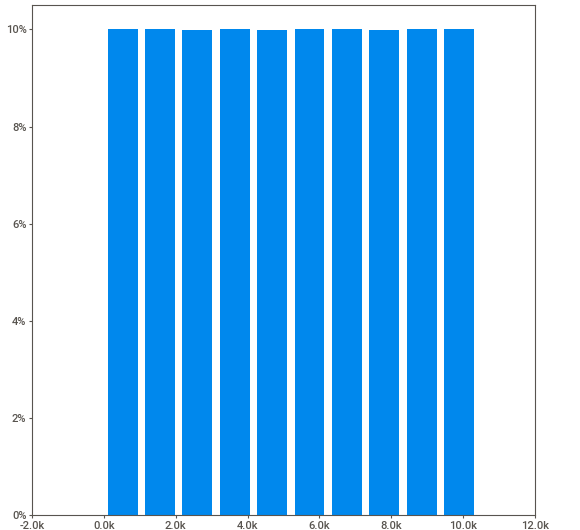
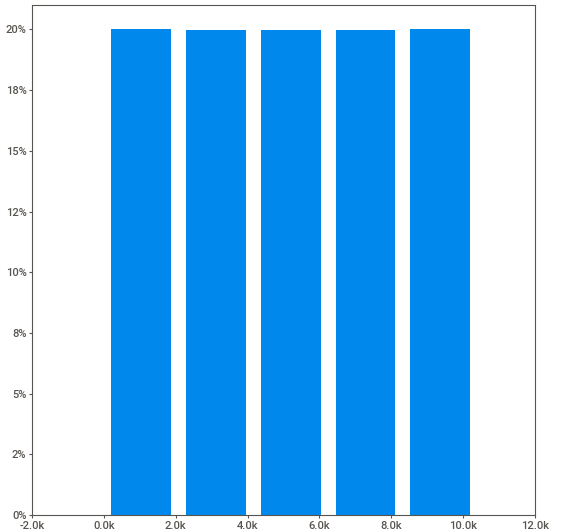
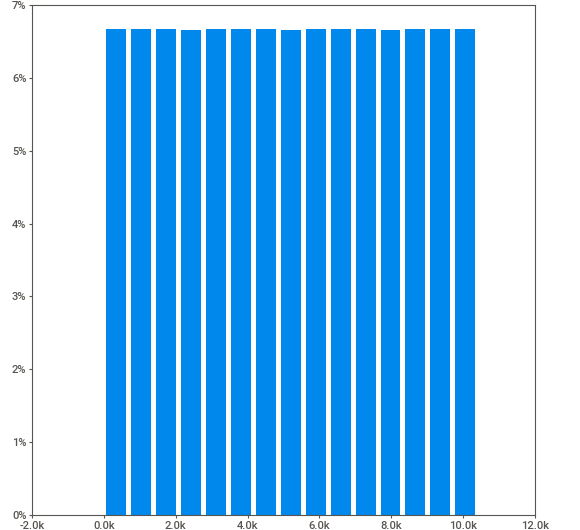
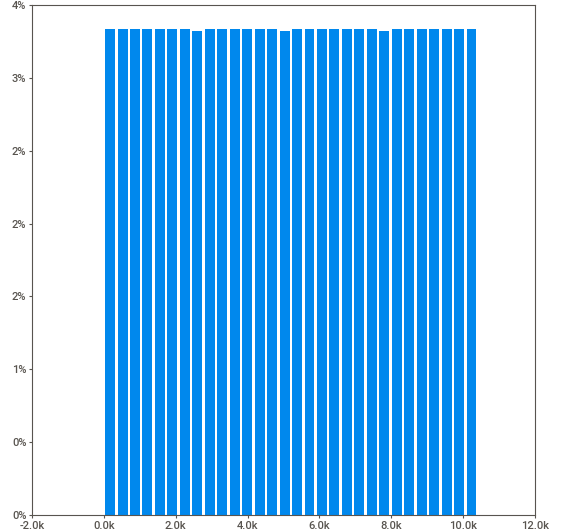
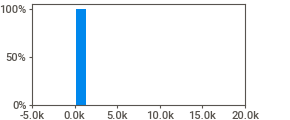
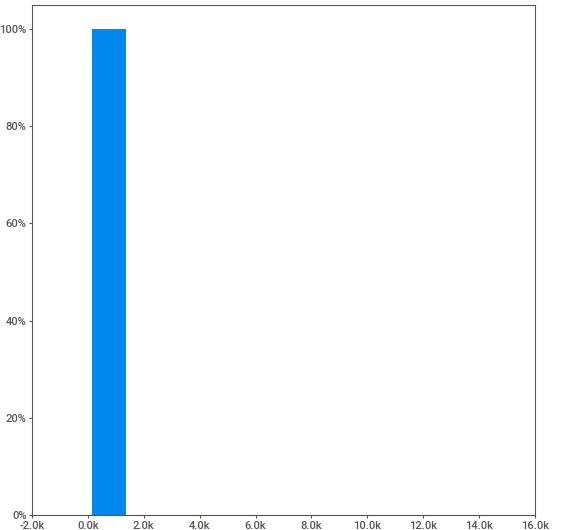
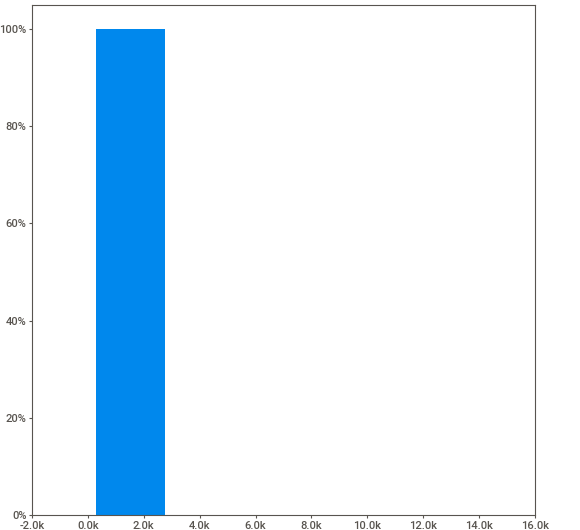
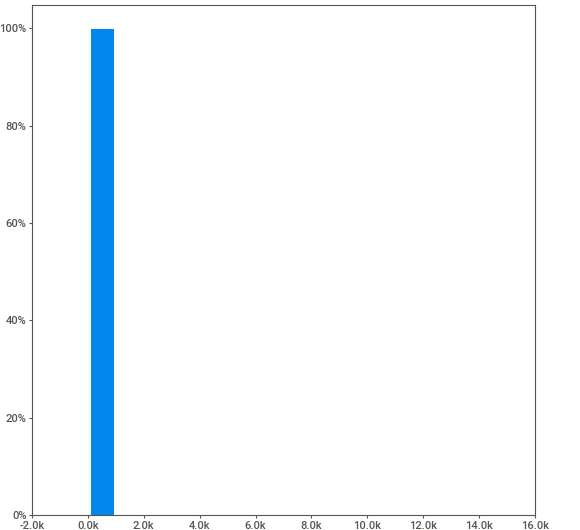
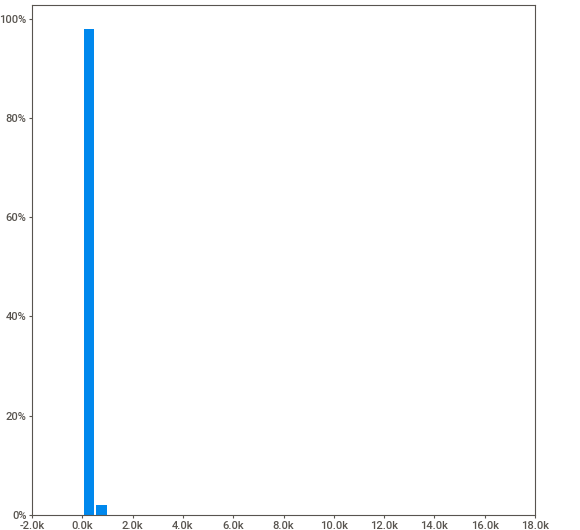
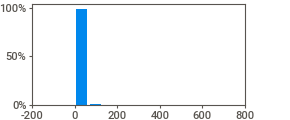
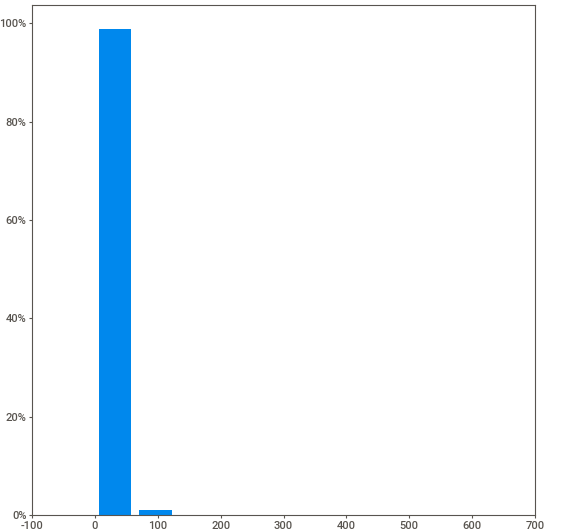
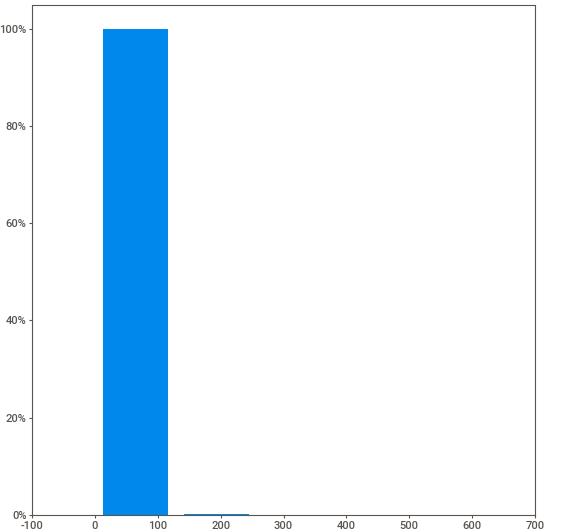
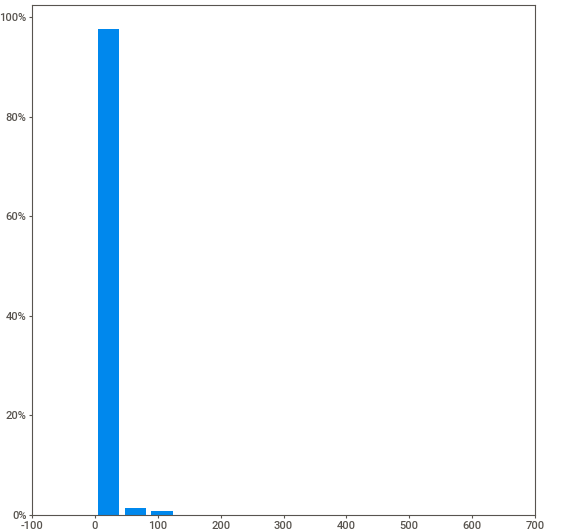
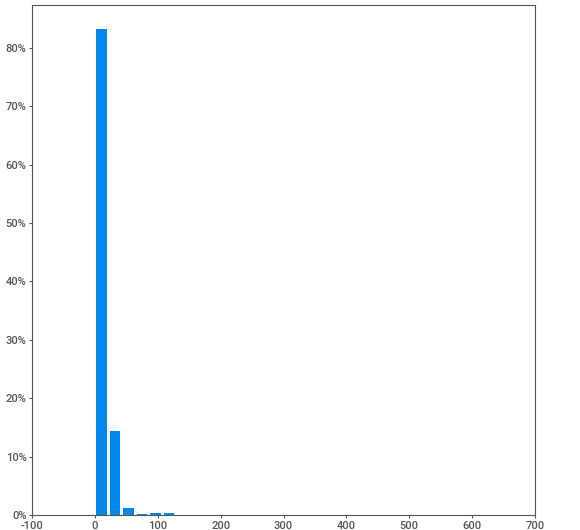
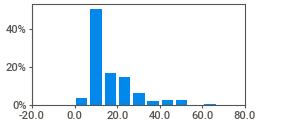
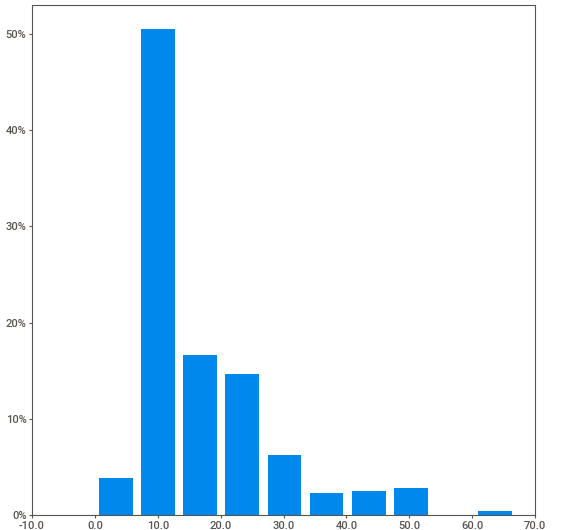
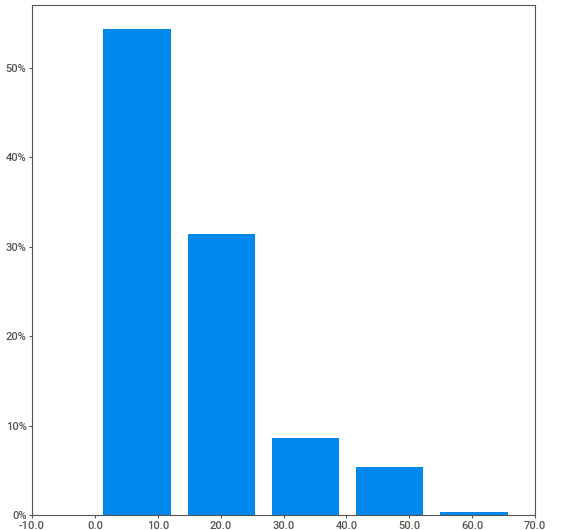
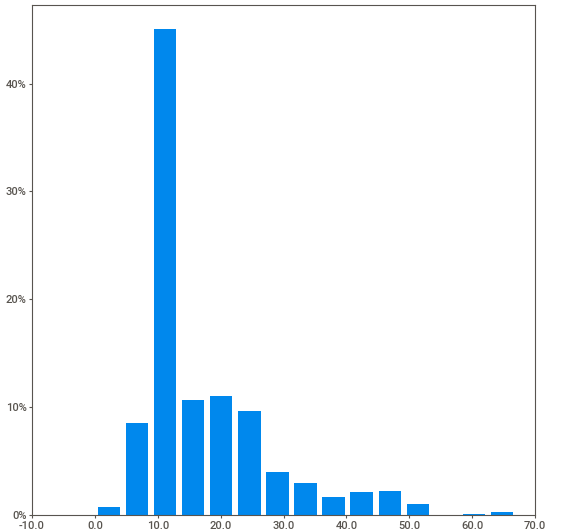
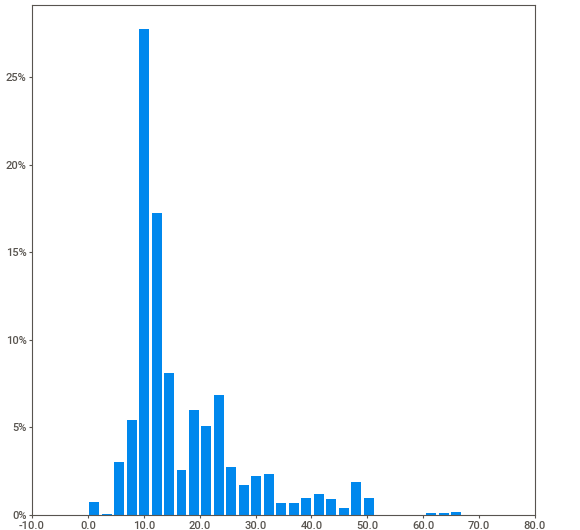
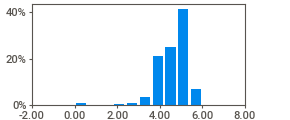
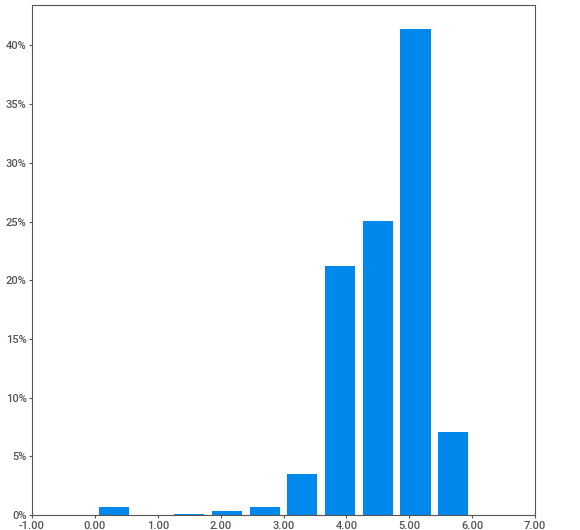
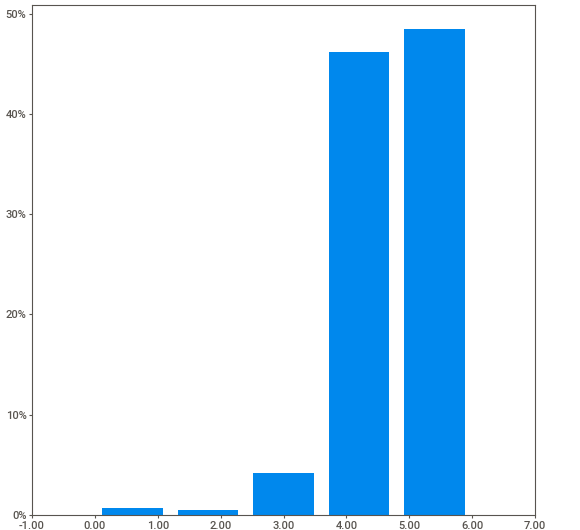
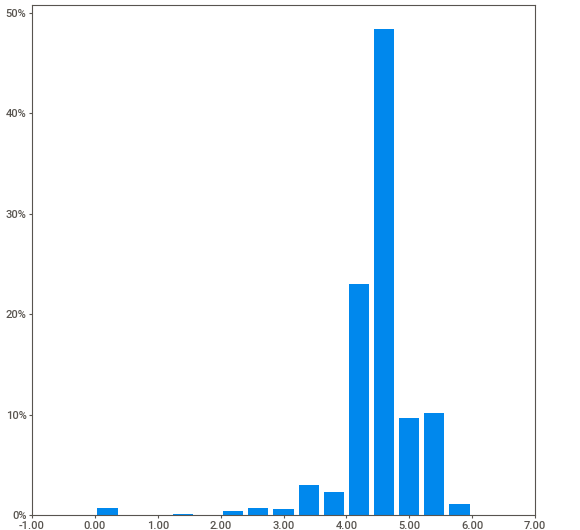
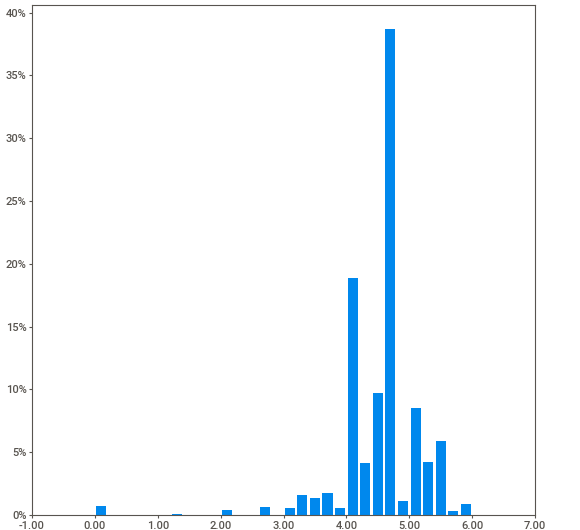
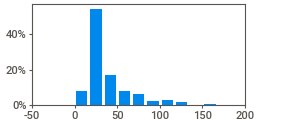
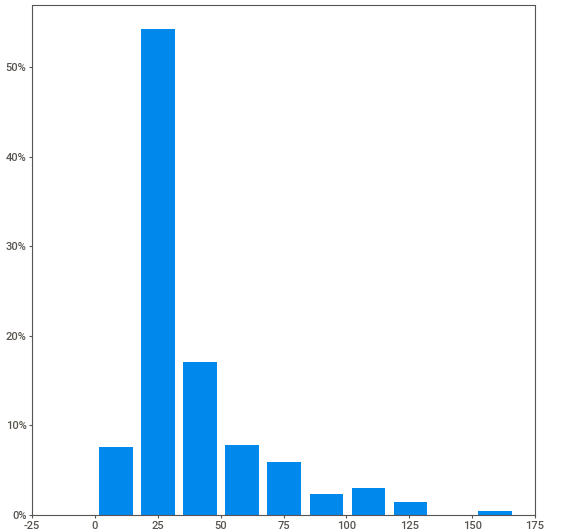
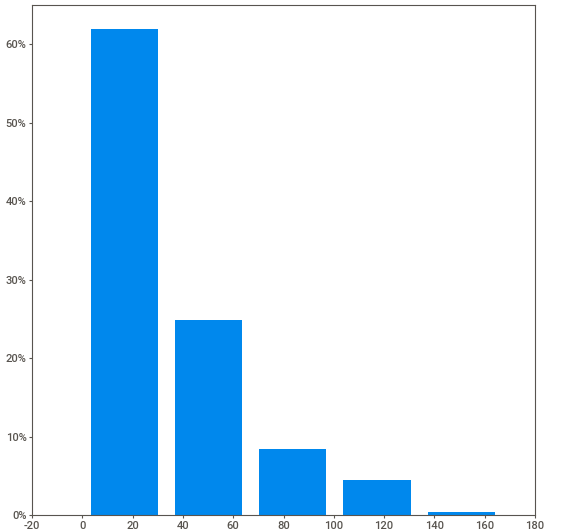
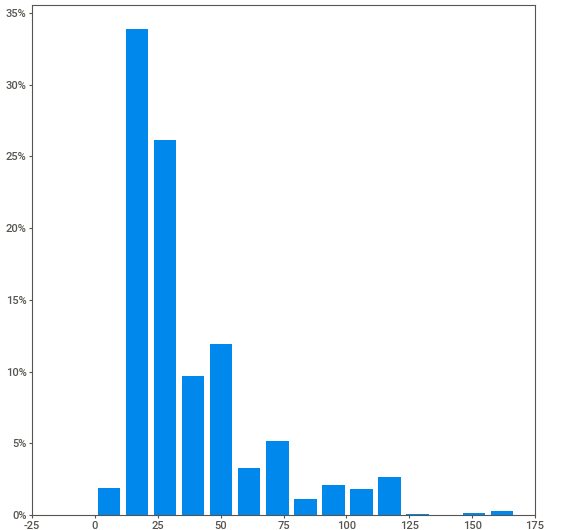
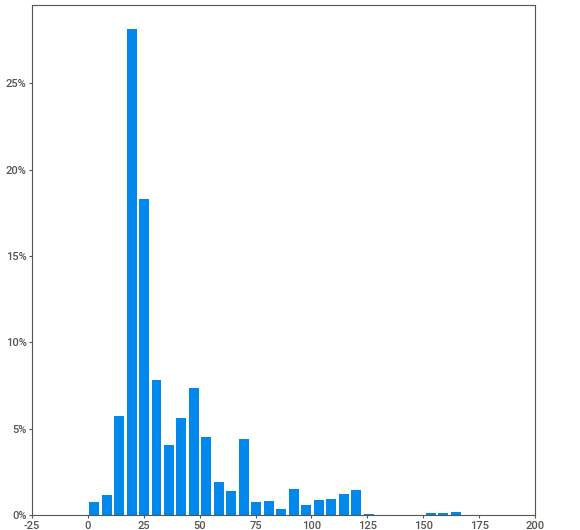
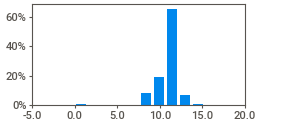
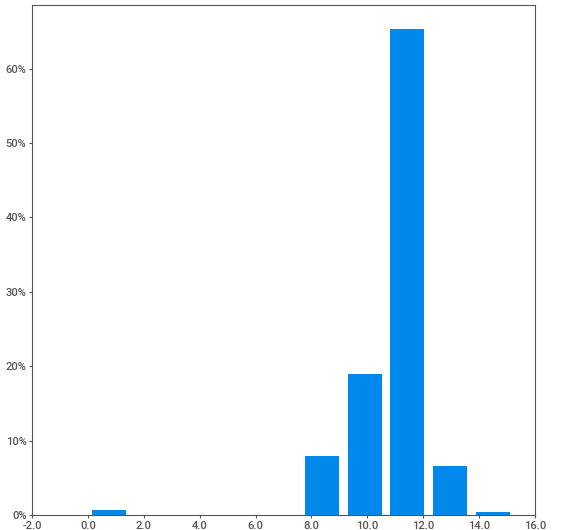
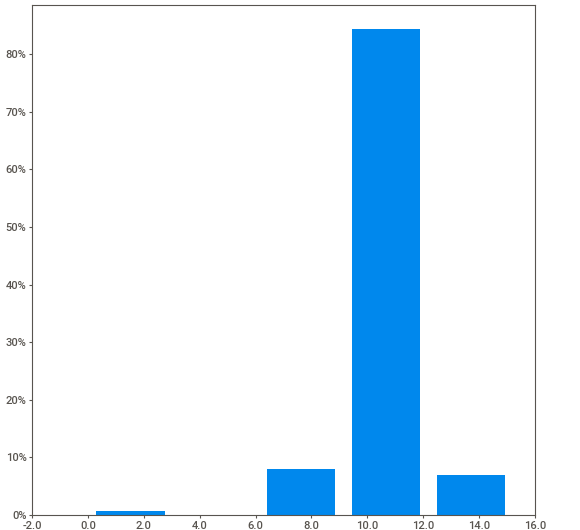
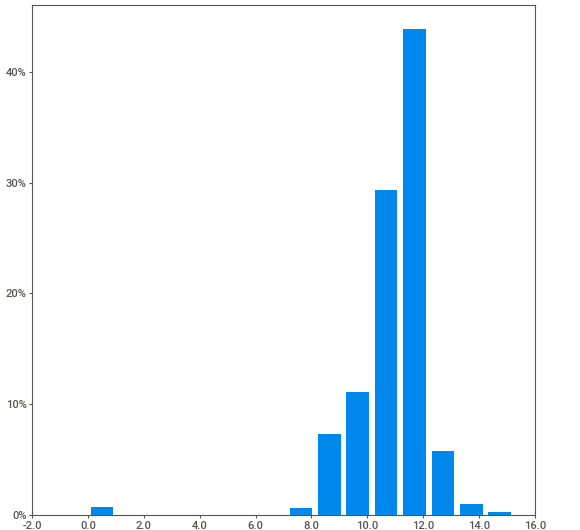
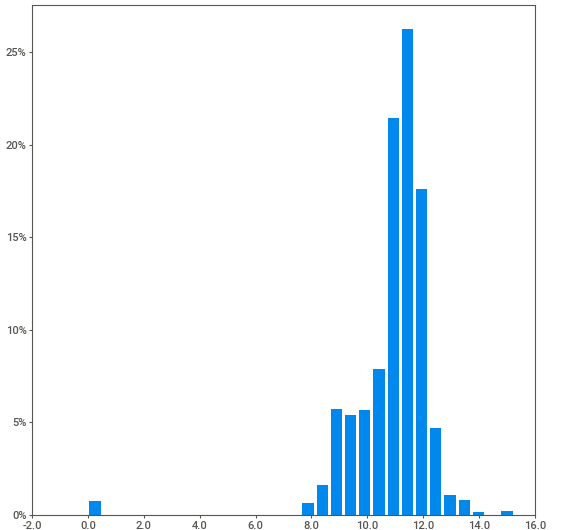
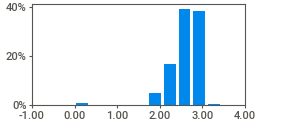
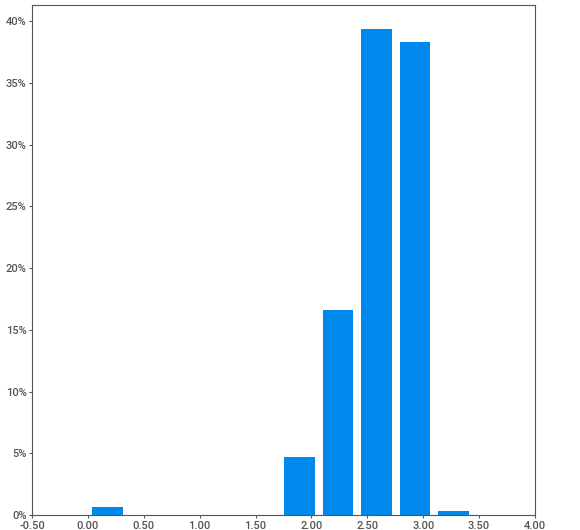
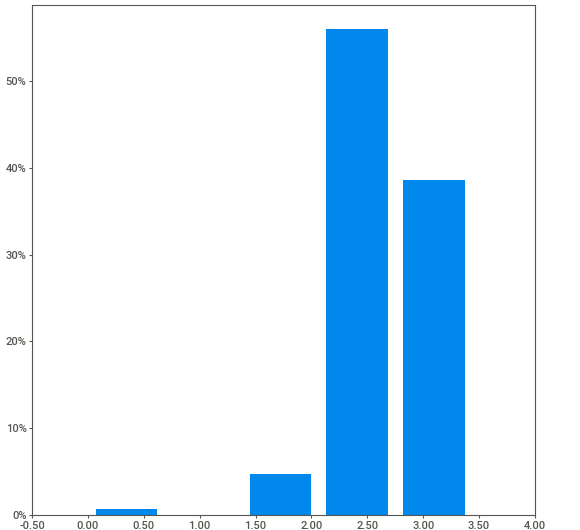
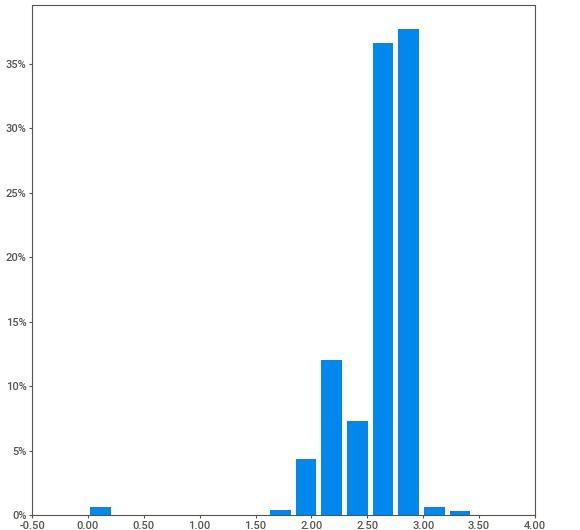
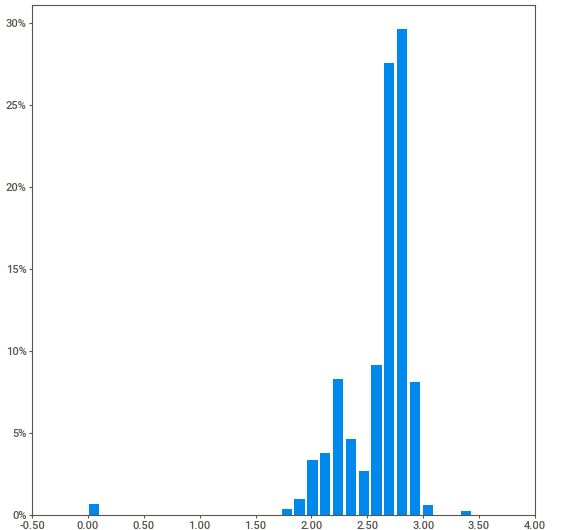
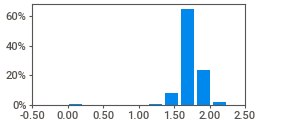
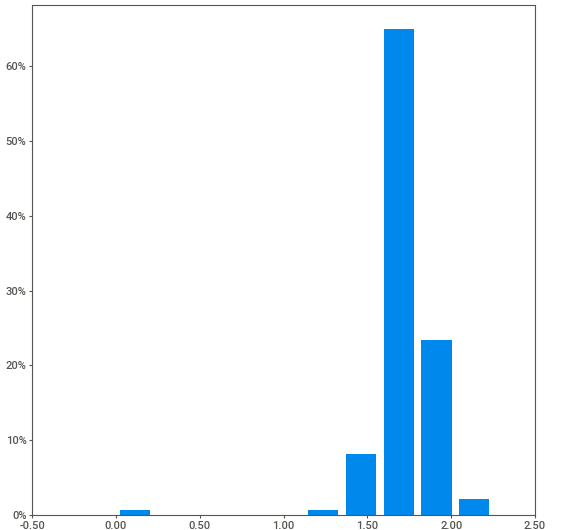
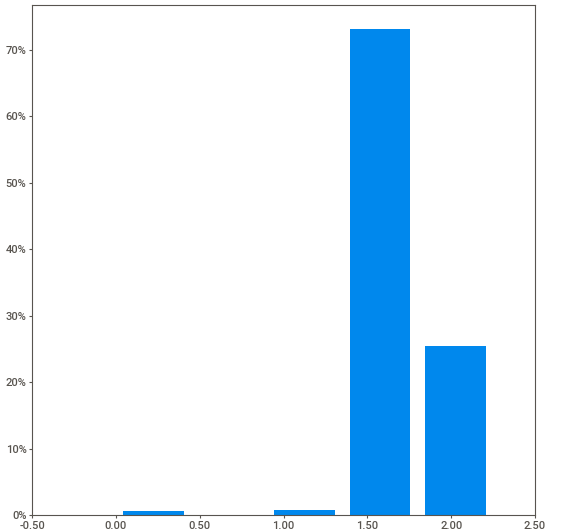
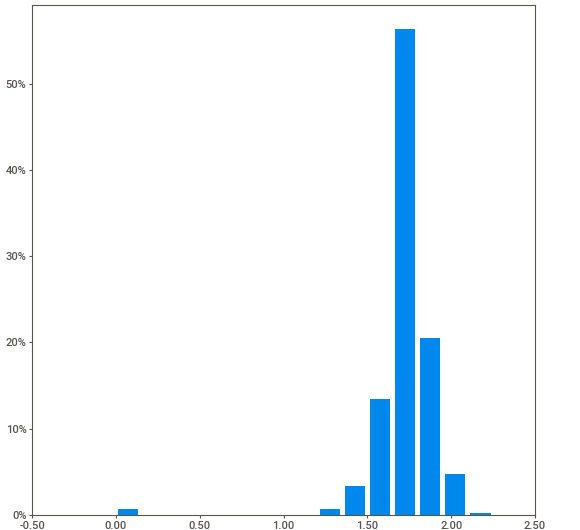
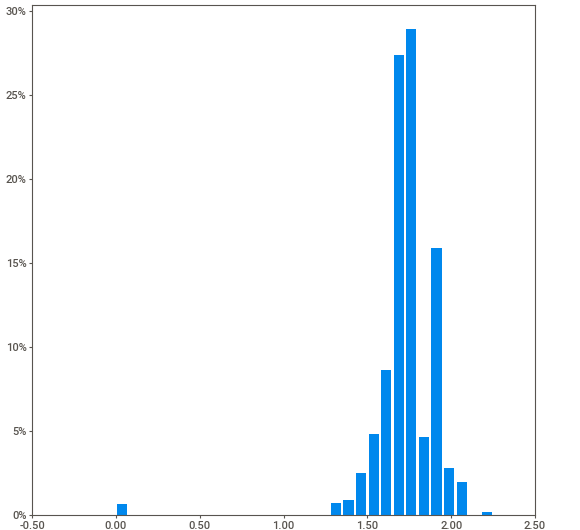
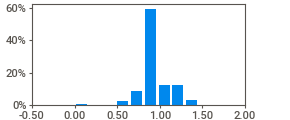
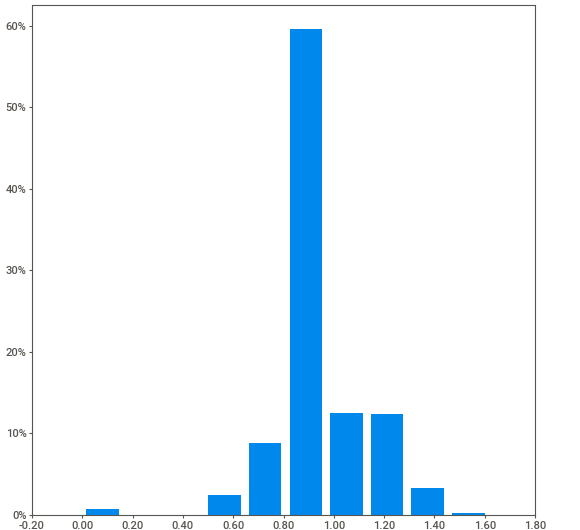
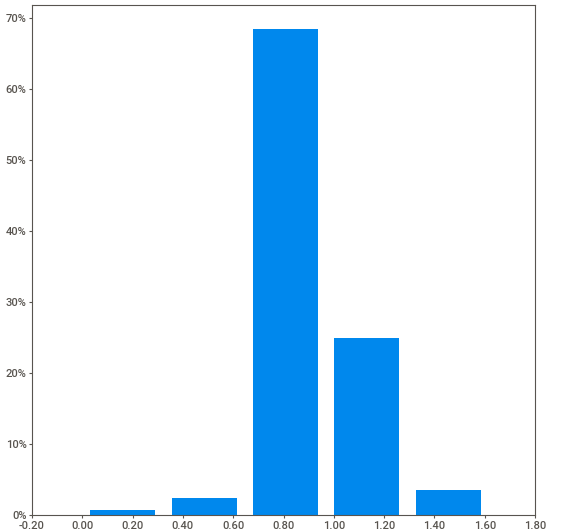
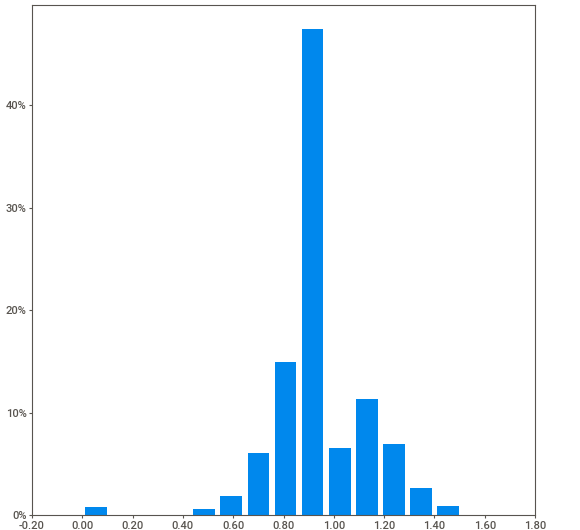
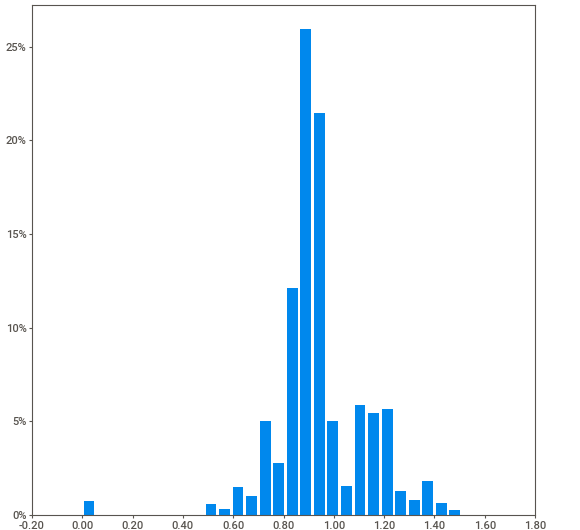
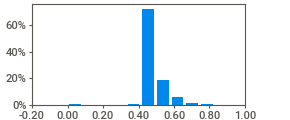
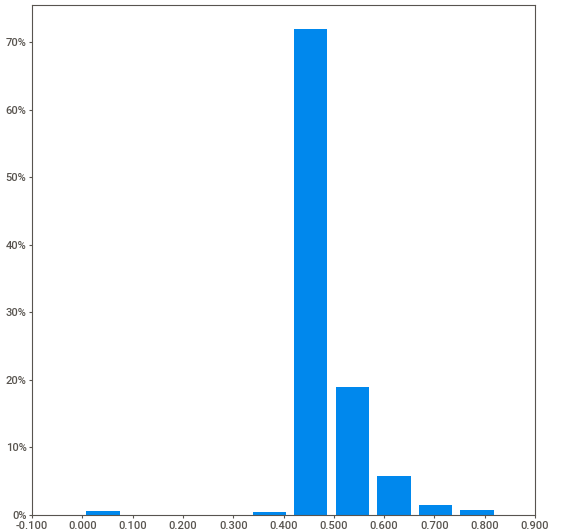
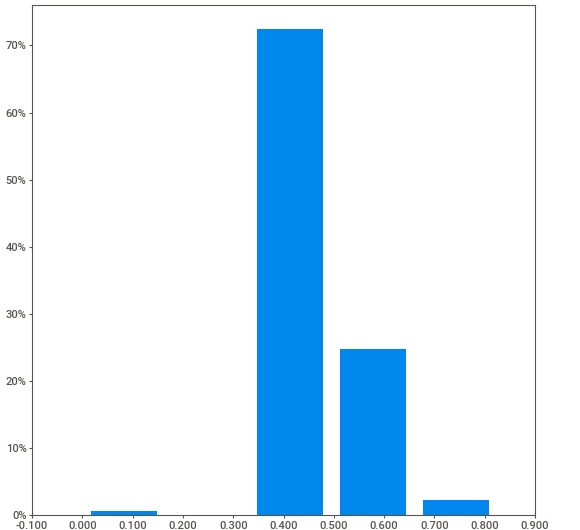
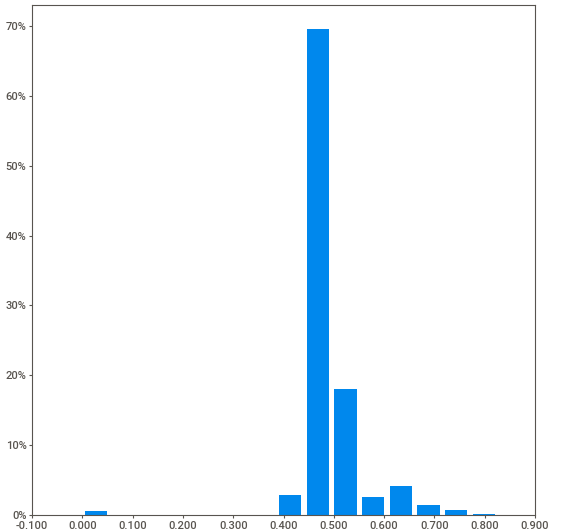
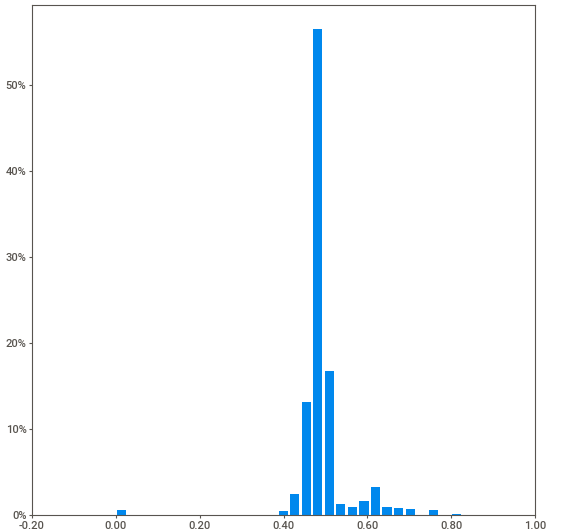
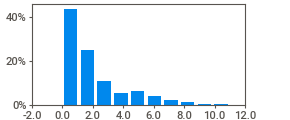
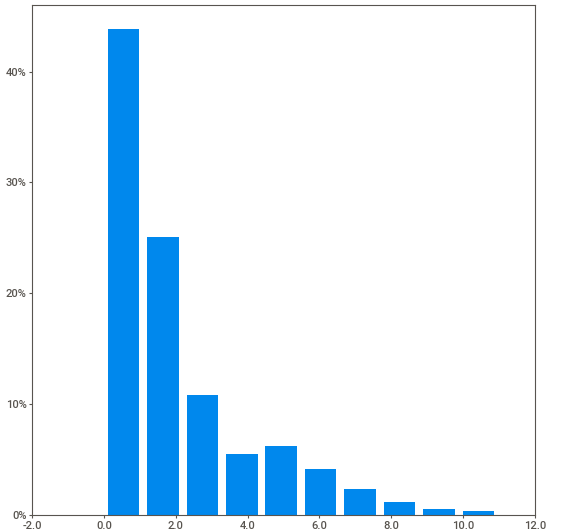
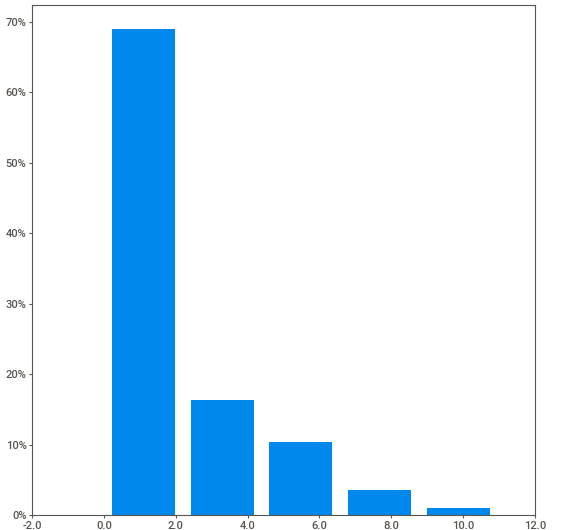
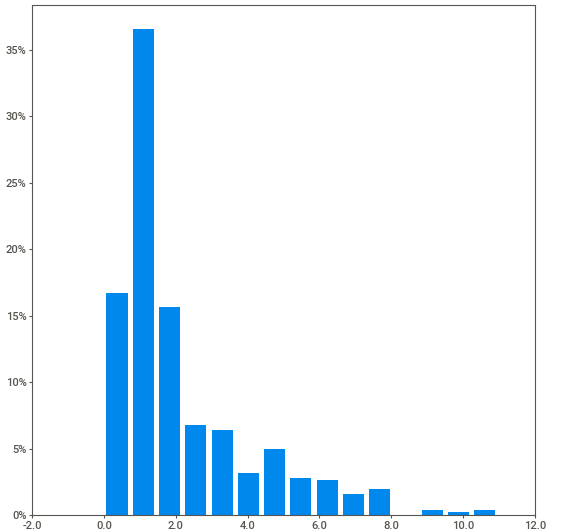
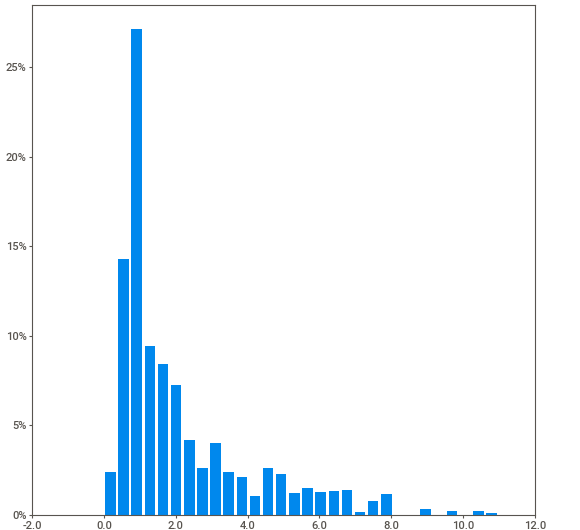
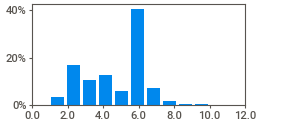
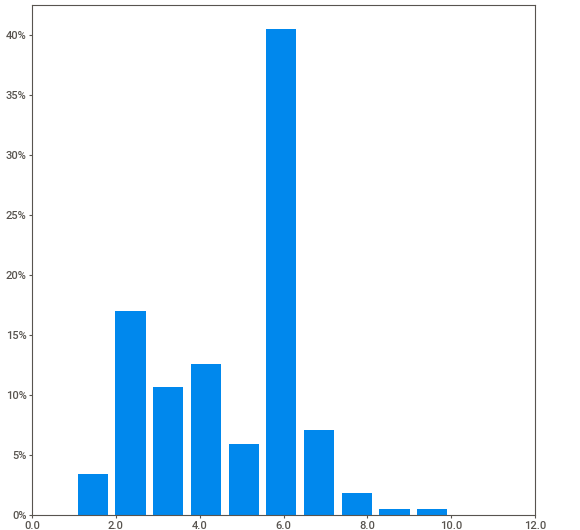
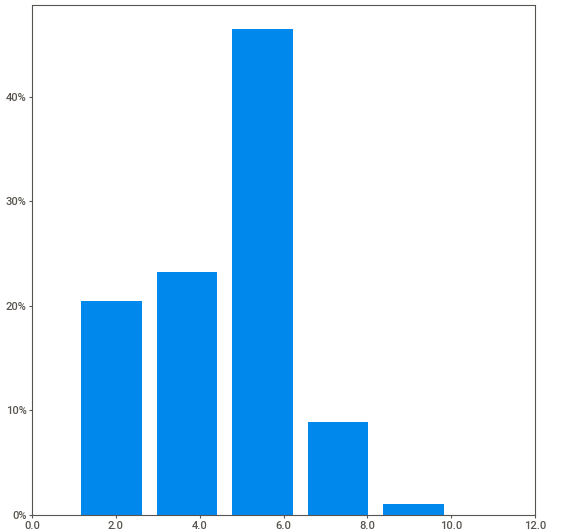
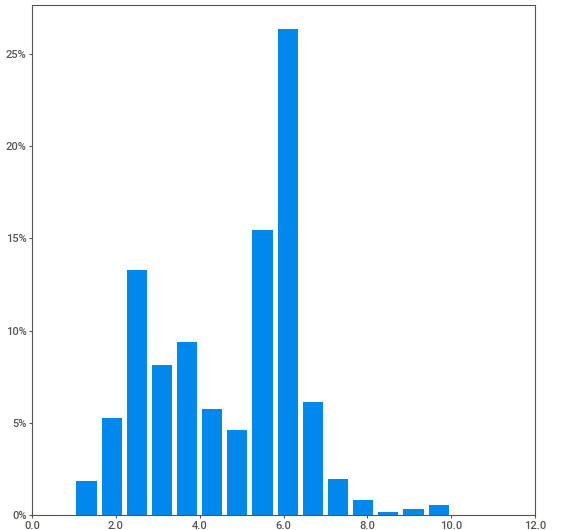
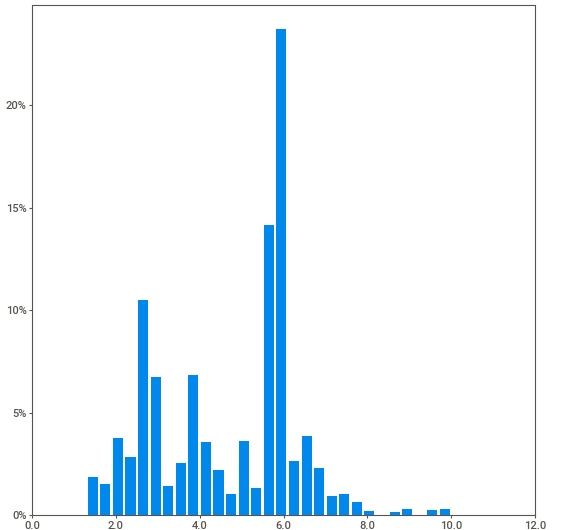
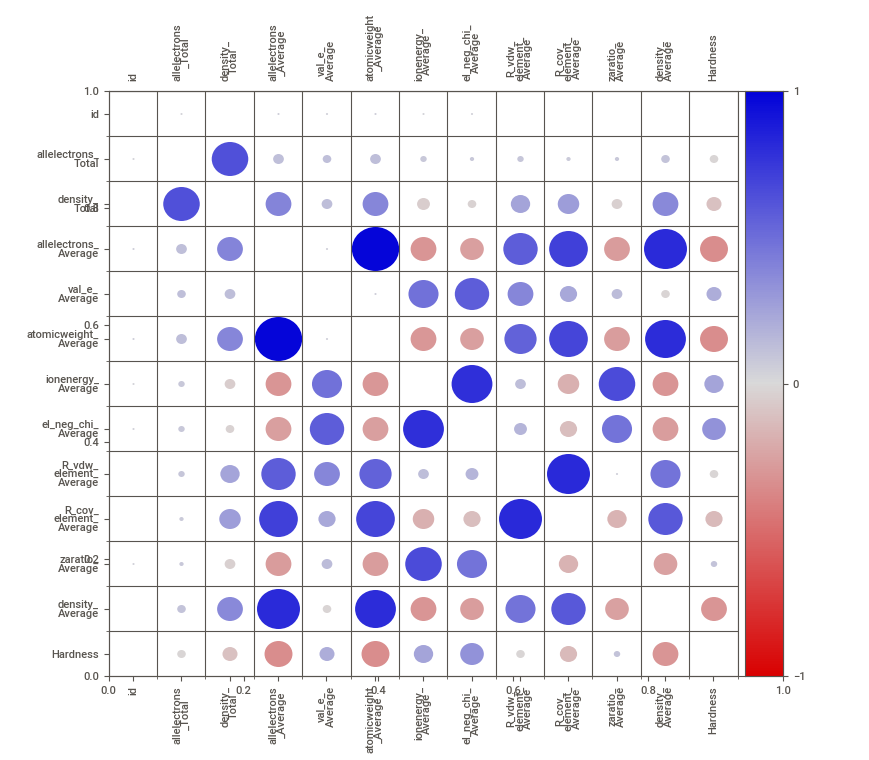
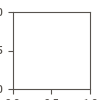

In [4]:
my_report = sv.analyze(train)
my_report.show_html()
my_report.show_notebook()

In [0]:
eda_ols(train.drop('id', axis=1), target_col)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [6]:
train.describe()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.00000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,5203.00000,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,3004.38646,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2601.50000,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,5203.00000,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,7804.50000,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,10406.00000,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


## EDA Insights

- 12 (11 + 1 target) numerical features in dataset, none are categorical. `id` is not of use in training set.
- No missing data

### feature observations
- `allelectrons_Total` and `density_Total` highly positive skew with significant peakedness. Mode concentration is 
high compared to range of data. Outliers present.
- Significant negative Pearson correlation for hardness: ['allelectrons_Average', 'atomicweight_Average', 
'density_Average']
- Significant positive Pearson correlation for hardness: ['el_neg_chi_Average', 'ionenergy_Average']

## Feature Engineering

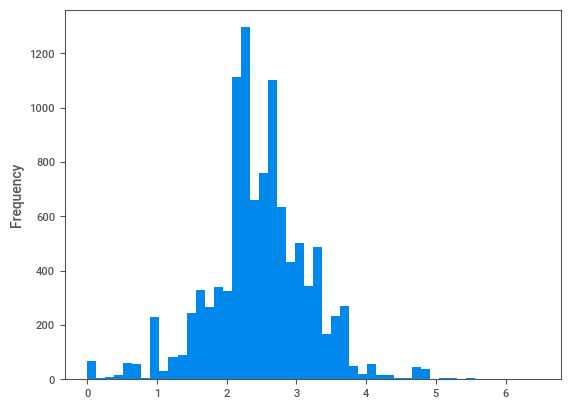

In [28]:
log_feature_names = ['allelectrons_Total', 'density_Total']

def log_transform(x):
    return np.log1p(x)  # Applies log(1+x) to the input

log_transformer_func = FunctionTransformer(log_transform)
# Create the ColumnTransformer
log_transformer = ColumnTransformer(
    transformers=[
        ('log_transform', log_transformer_func, log_feature_names)
    ],
    remainder='passthrough'  # This will pass through the other columns untouched
)

train_fe = train.copy()
for col in log_feature_names:
    train_fe[f'{col}_log'] = train_fe[col].apply(lambda x: np.log(1 + x))
    train_fe.drop(col, axis=1, inplace=True)
train_fe['density_Total_log'].plot(kind='hist', bins=50);

In [43]:

X = train[[col for col in train.columns if col not in  [target_col, 'id']]]
y = train[target_col]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


## Initial Approach: Linear Regression
Determine a baseline for error using a basic regression technique 

In [44]:

# Create a pipeline that first scales the data then applies linear regression
pipeline = Pipeline([
    ('log_transform', log_transformer),
    ('scaler', StandardScaler()),  # First step is to scale the data
    ('regressor', LinearRegression())  # Second step is the linear regression model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Now you can use the pipeline to make predictions
y_pred = pipeline.predict(X_test)

# Calculate the Median Absolute Error
mae = median_absolute_error(y_test, y_pred)
print(f'Linear Regression Median Absolute Error: {mae}')

Linear Regression Median Absolute Error: 0.9669382108231745


In [45]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=5)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
print(f'XGBoost Regression Median Absolute Error: {mae}')


XGBoost Regression Median Absolute Error: 0.7068177700042724


In [46]:
xgb_model = xgb.XGBRFRegressor(n_estimators=1000, max_depth=5)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
print(f'XGBoost RF Regression Median Absolute Error: {mae}')


XGBoost RF Regression Median Absolute Error: 0.7723056077957153


In [47]:
svr_model = SVR()
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
print(f'SVR Regression Median Absolute Error: {mae}')

SVR Regression Median Absolute Error: 0.9019036394186752


## Stacked model

In [51]:
linear_preprocessor = StandardScaler()

lasso_pipeline = make_pipeline(log_transformer, linear_preprocessor, LassoCV())
# svr_pipeline = make_pipeline(linear_preprocessor, SVR())
xgb_rf_pipeline = make_pipeline(log_transformer, xgb.XGBRFRegressor(n_estimators=10000, max_depth=10, 
                                                               random_state=random_state))
mlp_pipeline = make_pipeline(log_transformer, linear_preprocessor, 
                             MLPRegressor(
                                    hidden_layer_sizes=(1000, 1000, 1000),  # More layers and neurons
                                    activation='tanh',                   # Nonlinear activation function
                                    alpha=0.0001,                        # Regularization term
                                    learning_rate_init=0.001,            # Learning rate
                                    max_iter=10000,                        # More iterations
                                    early_stopping=True,                 # Early stopping
                                    random_state=random_state)
                             )

estimators = [
    # ("Support Vector", svr_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", xgb_rf_pipeline),
    ("MLP", mlp_pipeline),

]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=xgb.XGBRegressor(n_estimators=1000, max_depth=5, random_state=random_state))
stacking_regressor


StackingRegressor(estimators=[('Lasso',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('log_transform',
                                                                                 FunctionTransformer(func=<function log_transform at 0x159080f40>),
                                                                                 ['allelectrons_Total',
                                                                                  'density_Total'])])),
                                               ('standardscaler',
                                                StandardScaler()),
                                               ('lassocv', LassoCV())])),
                              ('Gradient Boosting',
                               Pipeline(steps...
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=5,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=1000, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=42, ...))

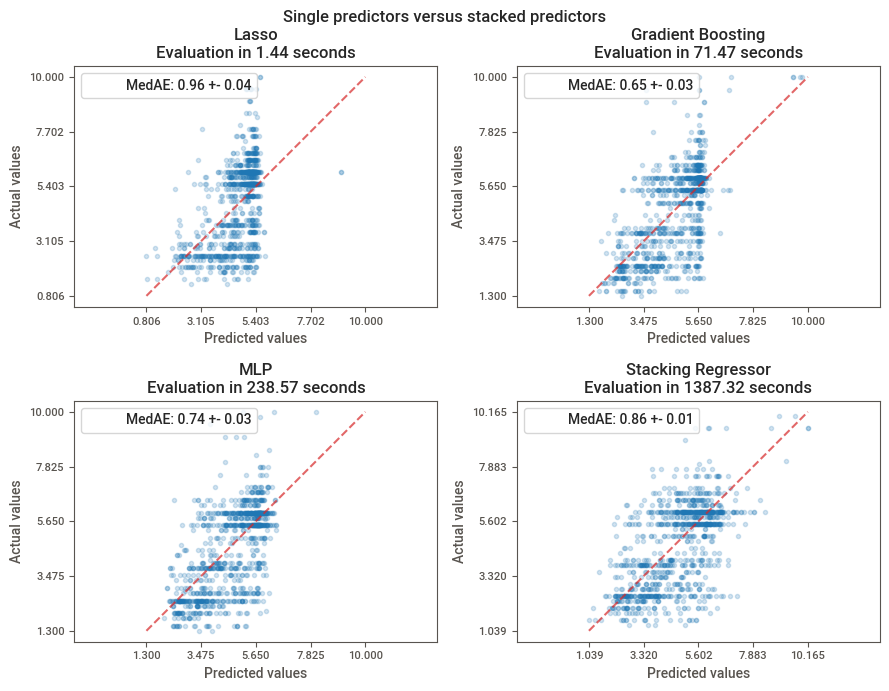

In [52]:
import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

scorers = {"MedAE": "neg_median_absolute_error"}

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):

    start_time = time.time()
    scores = cross_validate(
        est, X_train, y_train, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_train, y_train, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y_train,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [37]:
y_pred = cross_val_predict(stacking_regressor, X_train, y_train, n_jobs=-1, verbose=0)
mae = median_absolute_error(y_train, y_pred)
print(f'TRAIN: Stacked Regression Median Absolute Error: {mae}')

TRAIN: Stacked Regression Median Absolute Error: 0.6886468469971581


In [53]:
stacking_regressor.fit(X, y)

# y_pred = cross_val_predict(stacking_regressor, X_test, y_test, n_jobs=-1, verbose=0)
# stacking_regressor.predict(X_test)
y_submit = pd.DataFrame(stacking_regressor.predict(test.drop('id', axis=1)), index=test['id'], columns=[target_col])
# y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=True)
y_submit

,Hardness
id,
10407,2.789635
10408,2.560275
10409,5.873994
10410,5.209955
10411,5.068290
...,...
17341,5.617101
17342,4.963976
17343,5.012403
